In [52]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from IPython.display import Markdown, display, Image, display_html


import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/data.csv')

In [9]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [10]:
df.apply(lambda x: len(x.unique())).sort_values(ascending=False).head(10)

id                      569
smoothness_se           547
fractal_dimension_se    545
area_worst              544
concave points_mean     542
compactness_se          541
radius_se               540
area_mean               539
concavity_worst         539
compactness_mean        537
dtype: int64

Text(0, 0.5, 'Features')

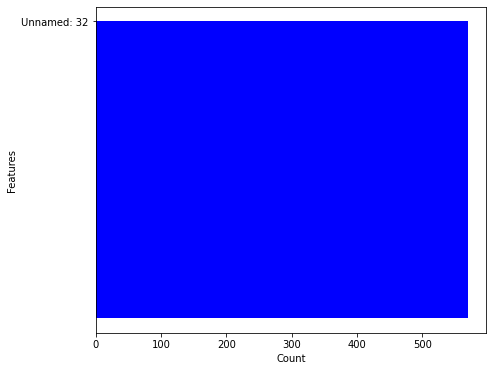

In [11]:
#cols_with_missing = [col for col in train.columns if train[col].isnull().any()]
cols_with_missing = df.isnull().sum()
cols_with_missing = cols_with_missing[cols_with_missing>0]
cols_with_missing.sort_values(inplace=True)
fig, ax = plt.subplots(figsize=(7,6))  
width = 0.70 # the width of the bars 
ind = np.arange(len(cols_with_missing))  # the x locations for the groups
ax.barh(ind, cols_with_missing, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(cols_with_missing.index, minor=False)
plt.xlabel('Count')
plt.ylabel('Features') 

In [21]:
df_diagnosis = df.diagnosis # M or B 
list_drp = ['Unnamed: 32','id','diagnosis']
df_extract = df.drop(list_drp,axis = 1 )

In [14]:
dups = df_extract.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df_extract[dups])

False
Empty DataFrame
Columns: [radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst]
Index: []

[0 rows x 30 columns]


In [60]:
print(df_extract.columns)

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [59]:
def view_df(df, subset=[], color='#004999'):
    df = df.reset_index()
    style = df.style.set_table_attributes("style='display:inline'").\
        bar(subset=subset, axis=1, color=color)\
        .format({"label": lambda x: x.upper()})\
        .set_properties(**{'background-color': 'white', 'color': 'black'})
    display_html(style._repr_html_(), raw=True)

In [82]:
df_extract.describe().T.style.bar(subset=['mean'], color='#004999')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
texture_mean,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
perimeter_mean,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
area_mean,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
smoothness_mean,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
compactness_mean,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
concavity_mean,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
concave points_mean,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
symmetry_mean,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000
fractal_dimension_mean,569.000000,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.097440


Number of Benign:  357
Number of Malignant :  212


/Users/yonastadesse/miniforge3/envs/week4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


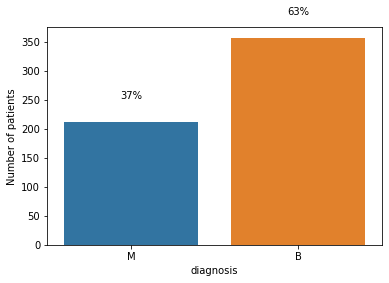

In [29]:
ax = sns.countplot(df_diagnosis,label="Count")       # M = 212, B = 357
B, M = df_diagnosis.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)
ax.set_ylabel('Number of patients')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

In [27]:
cols = df.columns
cols_numeric = df._get_numeric_data().columns
list(set(cols) - set(cols_numeric))

['diagnosis']

### The only categorical data we have is 'diagnosis'

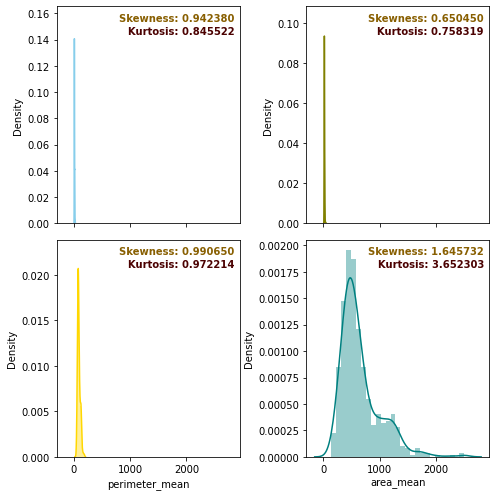

In [42]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(df_extract.iloc[:,0], color="skyblue", ax=axes[0,0])
sns.distplot(df_extract.iloc[:,1], color="olive", ax=axes[0,1])
sns.distplot(df_extract.iloc[:,2], color="gold", ax=axes[1,0])
sns.distplot(df_extract.iloc[:,3], color="teal", ax=axes[1,1])
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % df_extract.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % df_extract.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

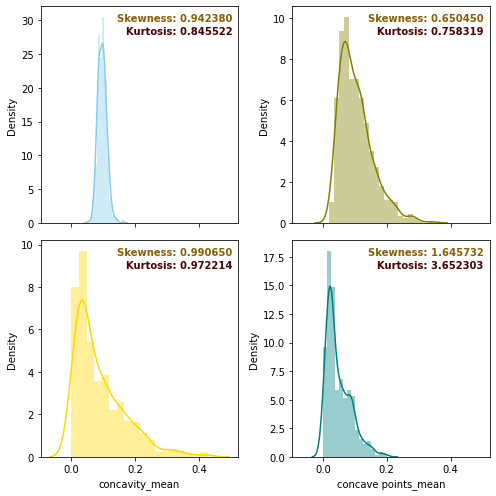

In [43]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(df_extract.iloc[:,4], color="skyblue", ax=axes[0,0])
sns.distplot(df_extract.iloc[:,5], color="olive", ax=axes[0,1])
sns.distplot(df_extract.iloc[:,6], color="gold", ax=axes[1,0])
sns.distplot(df_extract.iloc[:,7], color="teal", ax=axes[1,1])
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % df_extract.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % df_extract.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

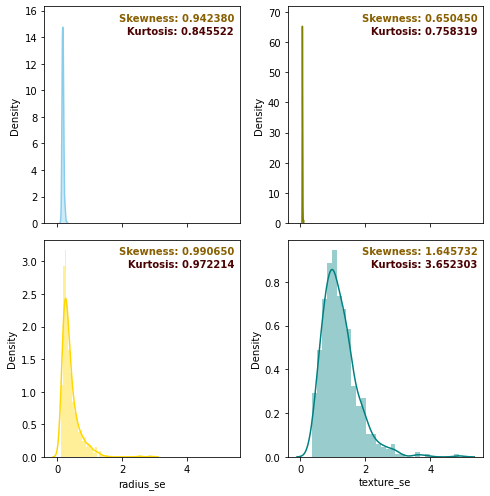

In [44]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(df_extract.iloc[:,8], color="skyblue", ax=axes[0,0])
sns.distplot(df_extract.iloc[:,9], color="olive", ax=axes[0,1])
sns.distplot(df_extract.iloc[:,10], color="gold", ax=axes[1,0])
sns.distplot(df_extract.iloc[:,11], color="teal", ax=axes[1,1])
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % df_extract.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % df_extract.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

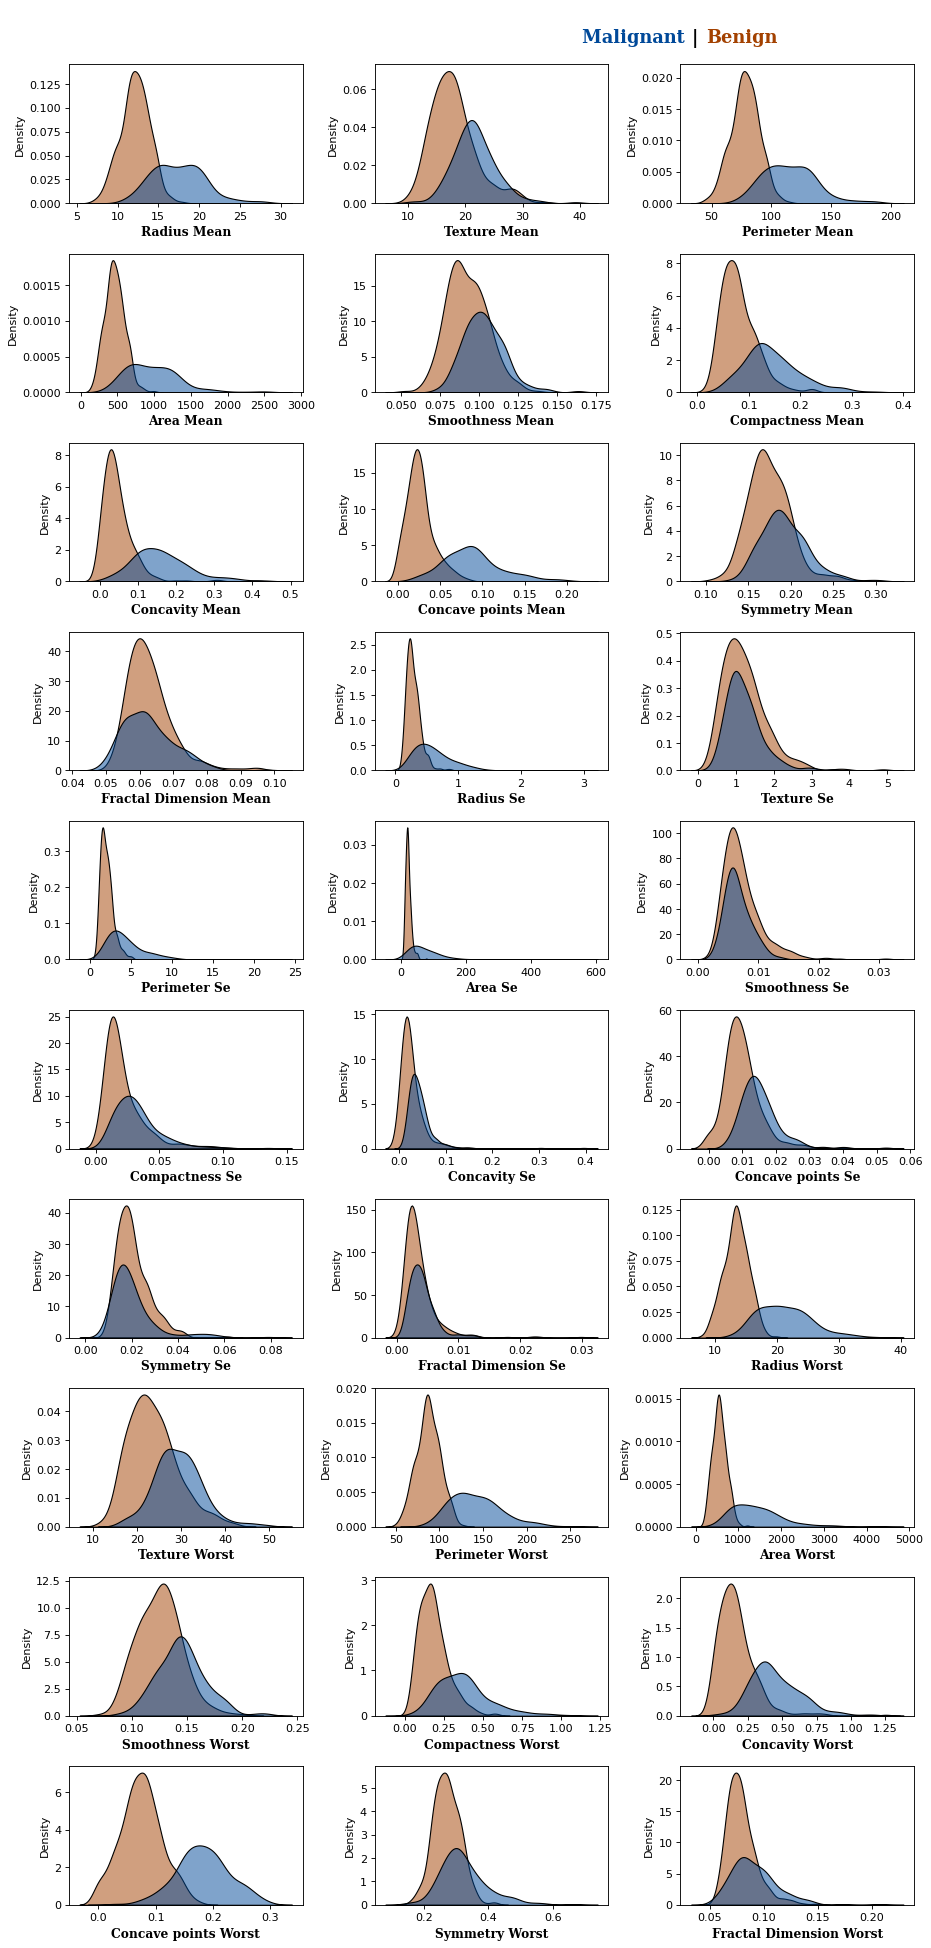

In [50]:
fig,ax = plt.subplots(nrows = 10, ncols = 3, figsize = (12,24),dpi=80)
axes = ax.ravel()

for col,ax in zip(df_extract.columns,axes):
    # plots
    sns.kdeplot(df[col], ax = ax, shade = True ,
                palette=["#004999", "#a34100"],
                alpha = 0.5, linewidth = 1, ec = 'black',
                hue = df['diagnosis'], hue_order = ['M','B'],
                legend = False)

    # plot setting
    xlabel = ' '.join([value.capitalize() for value in str(col).split('_') ])
    ax.axes.set_xlabel(xlabel,{'font':'serif','size':11, 'weight':'bold'}, alpha = 1)

plt.tight_layout(pad= 2,h_pad = 1, w_pad = 1)

fig.text(0.615,1, "\n Malignant",{'font':'serif','size':16, 'weight':'bold', 'color':"#004999"}, alpha = 1)
fig.text(0.735,1, '|',{'font':'serif','size':16, 'weight':'bold'})
fig.text(0.75,1, "Benign",{'font':'serif','size':16, 'weight':'bold','color':"#a34100"}, alpha = 1)

fig.show()

### The benign density in almost all of the features is greater. Therefore the infected one has lower density when compared to the uninfected ones.

In [51]:
class DfOutlier:

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def count_outliers(self, Q1, Q3, IQR, columns):
        cut_off = IQR * 1.5
        temp_df = (self.df[columns] < (Q1 - cut_off)) | (self.df[columns] > (Q3 + cut_off))
        return [len(temp_df[temp_df[col] == True]) for col in temp_df]

    def calc_skew(self, columns=None):
        if columns == None:
            columns = self.df.columns
        return [self.df[col].skew() for col in columns]

    def percentage(self, list):
        return [str(round(((value/150001) * 100), 2)) + '%' for value in list]

    def remove_outliers(self, columns):
        for col in columns:
            Q1, Q3 = self.df[col].quantile(0.25), self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            cut_off = IQR * 1.5
            lower, upper = Q1 - cut_off, Q3 + cut_off
            self.df = self.df.drop(self.df[self.df[col] > upper].index)
            self.df = self.df.drop(self.df[self.df[col] < lower].index)

    def replace_outliers_with_fences(self, columns):
        for col in columns:
            Q1, Q3 = self.df[col].quantile(0.25), self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            cut_off = IQR * 1.5
            lower, upper = Q1 - cut_off, Q3 + cut_off

            self.df[col] = np.where(self.df[col] > upper, upper, self.df[col])
            self.df[col] = np.where(self.df[col] < lower, lower, self.df[col])

    def getOverview(self, columns) -> None:
        min = self.df[columns].min()
        Q1 = self.df[columns].quantile(0.25)
        median = self.df[columns].quantile(0.5)
        Q3 = self.df[columns].quantile(0.75)
        max = self.df[columns].max()
        IQR = Q3 - Q1
        skew = self.calc_skew(columns)
        outliers = self.count_outliers(Q1, Q3, IQR, columns)
        cut_off = IQR * 1.5
        lower, upper = Q1 - cut_off, Q3 + cut_off

        new_columns = [
            'Name of columns',
            'Min',
            'Q1',
            'Median',
            'Q3',
            'Max',
            'IQR',
            'Lower fence',
            'Upper fence',
            'Skew',
            'Number_of_outliers',
            'Percentage_of_outliers' ]
        data = zip(
            [column for column in self.df[columns]],
            min,
            Q1,
            median,
            Q3,
            max,
            IQR,
            lower,
            upper,
            skew,
            outliers,
            self.percentage(outliers)
        )
        new_df = pd.DataFrame(data=data, columns=new_columns)
        new_df.set_index('Name of columns', inplace=True)
        return new_df.sort_values('Number_of_outliers', ascending=False)

In [55]:
def view_df(df, subset=[], color='#004999'):
    df = df.reset_index()
    style = df.style.set_table_attributes("style='display:inline'").\
        bar(subset=subset, axis=1, color=color)\
        .format({"label": lambda x: x.upper()})\
        .set_properties(**{'background-color': 'white', 'color': 'black'})
    display_html(style._repr_html_(), raw=True)

In [56]:
outlier_handler = DfOutlier(df)
columns = df.select_dtypes('float64').columns.tolist()
df_ = outlier_handler.getOverview(columns)
view_df(df_, ['Min', 'Q1', 'Median', "Q3", "Max", "IQR", "Lower fence", "Upper fence", "Skew", "Number_of_outliers"])

,Name of columns,Min,Q1,Median,Q3,Max,IQR,Lower fence,Upper fence,Skew,Number_of_outliers,Percentage_of_outliers
0,area_se,6.802000,17.850000,24.530000,45.190000,542.200000,27.340000,-23.160000,86.200000,5.447186,65,0.04%
1,radius_se,0.111500,0.232400,0.324200,0.478900,2.873000,0.246500,-0.137350,0.848650,3.088612,38,0.03%
2,perimeter_se,0.757000,1.606000,2.287000,3.357000,21.980000,1.751000,-1.020500,5.983500,3.443615,38,0.03%
3,area_worst,185.200000,515.300000,686.500000,1084.000000,4254.000000,568.700000,-337.750000,1937.050000,1.859373,35,0.02%
4,smoothness_se,0.001713,0.005169,0.006380,0.008146,0.031130,0.002977,0.000703,0.012612,2.314450,30,0.02%
5,fractal_dimension_se,0.000895,0.002248,0.003187,0.004558,0.029840,0.002310,-0.001217,0.008023,3.923969,28,0.02%
6,compactness_se,0.002252,0.013080,0.020450,0.032450,0.135400,0.019370,-0.015975,0.061505,1.902221,28,0.02%
7,symmetry_se,0.007882,0.015160,0.018730,0.023480,0.078950,0.008320,0.002680,0.035960,2.195133,27,0.02%
8,area_mean,143.500000,420.300000,551.100000,782.700000,2501.000000,362.400000,-123.300000,1326.300000,1.645732,25,0.02%
9,fractal_dimension_worst,0.055040,0.071460,0.080040,0.092080,0.207500,0.020620,0.040530,0.123010,1.662579,24,0.02%


In [57]:
outlier_handler.replace_outliers_with_fences(df_extract.columns)

In [58]:
df_extract.to_csv('../data/data_outlier_handled.csv')